### Load Packages

In [8]:
from sklearn.datasets import load_wine 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt 

### Load and prepare data

In [2]:
x, y = load_wine(return_X_y=True, as_frame=True)
scaler = StandardScaler().set_output(transform='pandas')

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

scaled_x_train = scaler.fit_transform(x_train) # transform = 'pandas'

### Effect of rescaling on a k-neighbors models

In [6]:
x_plot = x.loc[:, ['proline', 'hue']]
x_plot_scaled = scaler.fit_transform(x_plot)

(-2.0947324050170844, 3.3016942153020326)

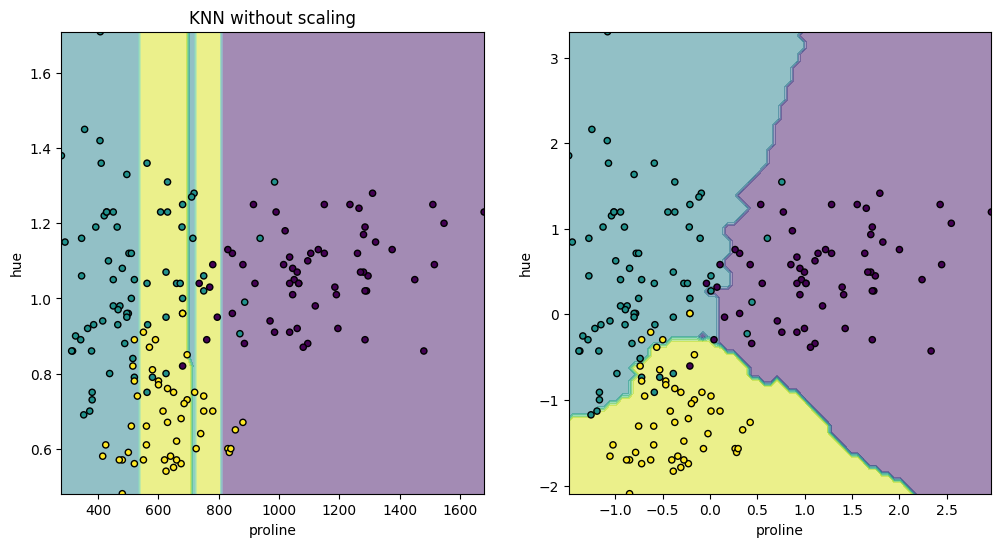

In [14]:
knn = KNeighborsClassifier(n_neighbors=20)

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

# without feature scaling
knn.fit(x_plot, y)
axes[0].set_title('KNN without scaling')
disp1 = DecisionBoundaryDisplay.from_estimator(
    knn, x_plot, response_method='predict', alpha=0.5, ax=axes[0])
disp1.ax_.scatter(x_plot['proline'], x_plot['hue'], c=y, s=20, edgecolor='k')
disp1.ax_.set_xlim((x_plot['proline'].min(), x_plot['proline'].max()))
disp1.ax_.set_ylim((x_plot['hue'].min(), x_plot['hue'].max()))


knn.fit(x_plot_scaled, y)
disp2 = DecisionBoundaryDisplay.from_estimator(
    knn, x_plot_scaled, response_method='predict', alpha=0.5, ax=axes[1])

disp2.ax_.scatter(x_plot_scaled['proline'], x_plot_scaled['hue'], c=y, s=20, edgecolor='k')
disp2.ax_.set_xlim((x_plot_scaled['proline'].min(), x_plot_scaled['proline'].max()))
disp2.ax_.set_ylim((x_plot_scaled['hue'].min(), x_plot_scaled['hue'].max()))

### Effect of rescaling on a PCA dimensional reduction

In [15]:
import pandas as pd 
from sklearn.decomposition import PCA

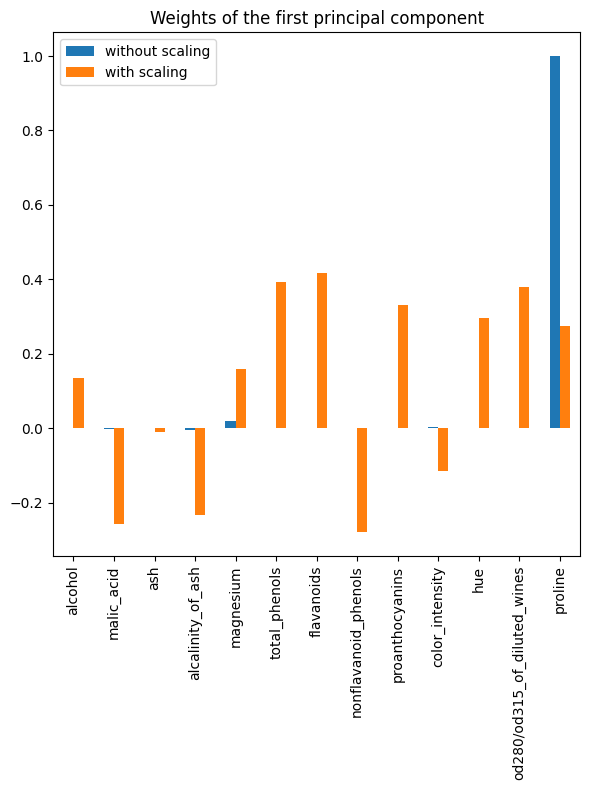

In [16]:
pca = PCA(n_components=2).fit(x_train)
scaled_pca = PCA(n_components=2).fit(scaled_x_train)

x_train_transformed = pca.transform(x_train)
scaled_x_train_transformed = scaled_pca.transform(scaled_x_train)

first_pca_component = pd.DataFrame(
    pca.components_[0], index=x.columns, columns=['without scaling']
)

first_pca_component['with scaling'] = scaled_pca.components_[0]

first_pca_component.plot.bar(
    title='Weights of the first principal component', figsize=(6, 8)
)

plt.tight_layout()

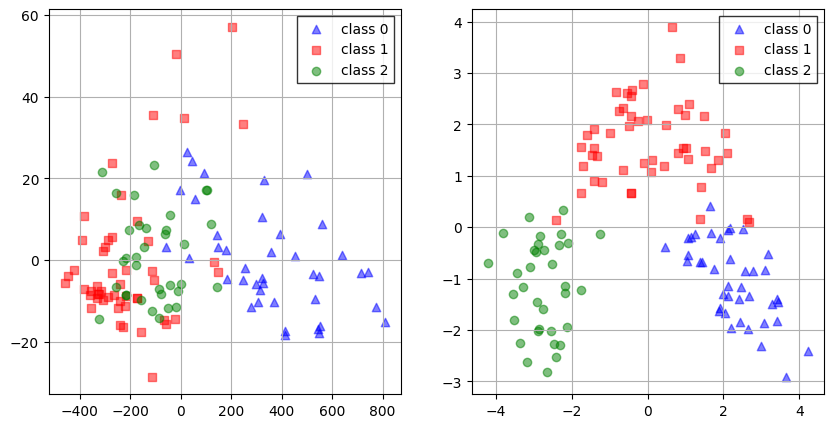

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
colors = ('blue', 'red', 'green')
markers = ('^', 's', 'o')

for target_class, (color, marker) in enumerate(zip(colors, markers)):
    axes[0].scatter(
        x=x_train_transformed[y_train == target_class, 0], 
        y=x_train_transformed[y_train == target_class, 1], 
        color=color, 
        label=f'class {target_class}', 
        alpha=0.5, 
        marker=marker
    )
    
    axes[1].scatter(
        x=scaled_x_train_transformed[y_train == target_class, 0], 
        y=scaled_x_train_transformed[y_train == target_class, 1], 
        color=color, 
        label=f'class {target_class}',
        alpha=0.5, 
        marker=marker
    )
axes[0].legend(edgecolor='black', fancybox=False)
axes[0].grid()

axes[1].legend(edgecolor='black', fancybox=False)
axes[1].grid()

plt.show()


### Effect of rescaling on model's performance

In [49]:
import numpy as np 
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score, log_loss

In [36]:
logspace = np.logspace(-5, 5, 20)

lr = make_pipeline(pca, LogisticRegressionCV(Cs=logspace))
lr.fit(x_train, y_train)

scaled_lr = make_pipeline(scaler, pca, LogisticRegressionCV(Cs=logspace))
scaled_lr.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])))])

In [47]:
y_pred = lr.predict(x_test)
y_proba = lr.predict_proba(x_test)

y_pred_scaled = scaled_lr.predict(x_test)
y_proba_scaled = scaled_lr.predict_proba(x_test)

In [48]:
print("Test accuracy for the unscaled PCA")
print(f"{accuracy_score(y_test, y_pred):.2%}\n")
print("Test accuracy for the standardized data with PCA")
print(f"{accuracy_score(y_test, y_pred_scaled):.2%}\n")
print("Log-loss for the unscaled PCA")
print(f"{log_loss(y_test, y_proba):.3}\n")
print("Log-loss for the standardized data with PCA")
print(f"{log_loss(y_test, y_proba_scaled):.3}")

Test accuracy for the unscaled PCA
35.19%

Test accuracy for the standardized data with PCA
96.30%

Log-loss for the unscaled PCA
2.07

Log-loss for the standardized data with PCA
0.0824
